In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, matplotlib as mpl, seaborn as sns, warnings

%matplotlib inline
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
plt.rc('font', family='NanumGothic')
rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False

plt.style.use('ggplot')
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]

warnings.filterwarnings(action='ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import LinearSVR, SVR
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [2]:
df_raw = pd.read_csv('./data/jeju_data_ver1/201901-202003.csv')

In [3]:
df_raw.head()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3


#### 1, 2, 3월 데이터만 추출

In [52]:
# df = df_raw[(df_raw['REG_YYMM'] == 202001) | (df_raw['REG_YYMM'] == 202002) | (df_raw['REG_YYMM'] == 202003)]
# df.head()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
20425415,202001,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,2,1,3,345000,3
20425416,202001,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,3,1903450,3
20425417,202001,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,14,1520500,15
20425418,202001,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,9,1239200,9
20425419,202001,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,606700,4


#### 서울 데이터만 추출

In [73]:
df = df_raw[df_raw['CARD_SIDO_NM']=='서울']

In [74]:
df.fillna('세종시', inplace=True)

In [75]:
df.columns

Index(['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM',
       'HOM_CCG_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'CSTMR_CNT', 'AMT', 'CNT'],
      dtype='object')

In [76]:
df.drop(['CARD_CCG_NM','HOM_SIDO_NM','HOM_CCG_NM'], axis=1, inplace=True)

In [77]:
df = df.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AGE', 'SEX_CTGO_CD', 'FLC']).sum().reset_index()

# 군집분석

In [78]:
new_df = df.groupby(['STD_CLSS_NM'])['CSTMR_CNT', 'AMT', 'CNT'].median().reset_index()

cl_df = new_df[['CSTMR_CNT', 'AMT', 'CNT']]
cl_df.tail()

,CSTMR_CNT,AMT,CNT
34,62590.0,1.508213e+09,199353.0
35,22271.0,2.823205e+08,32212.0
36,60179.0,2.796446e+09,96416.0
37,1021.5,1.117293e+08,1981.0
38,4163.0,2.578811e+08,5637.0


#### 표준화 및 역할 정의

In [79]:
X_list = list(cl_df.columns)
# 데이터 표준화
scaler = StandardScaler()
new_df_x = scaler.fit_transform(cl_df[X_list])

## k-평균 군집분석

#### 군집 개수 찾기 : 각 데이터로부터 가장 가까운 군집 중심점까지의 거리 제곱합


In [80]:
# 최대 군집 생성 개수
n_iter_cluster = 3
cluster_range = [i+1 for i in range(n_iter_cluster)]
clus_error = []
for v_n_clus in cluster_range : 
    clus = KMeans(v_n_clus)
    clus.fit(new_df_x)
    # 각 데이터로 부터 가장 가까운 군집 중심점까지 거리 제곱합
    clus_error.append(clus.inertia_)
ds_error = pd.DataFrame({'NumberofCluster' : cluster_range,
                        'Error' : clus_error})
ds_error

,NumberofCluster,Error
0,1,117.000000
1,2,30.129741
2,3,16.764385


#### 4-2) 군집별 군집 중시점까지 거리 제곱합 시각화

Text(0, 0.5, 'Sum of squared distance')

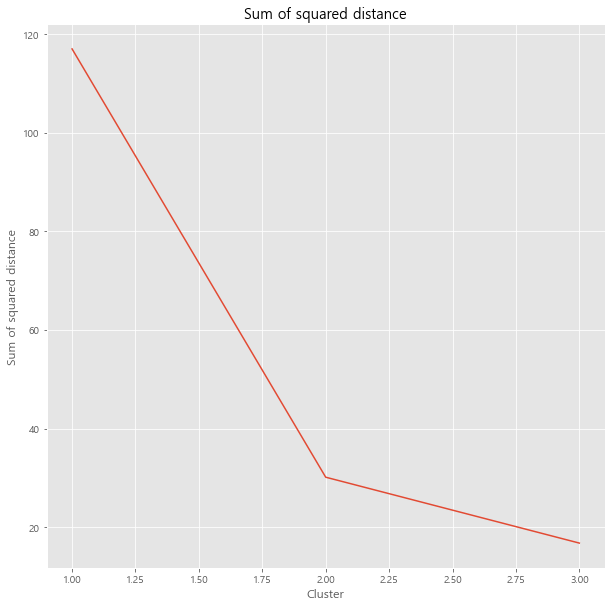

In [81]:
plt.figure(figsize = (10,10))
plt.plot(ds_error['NumberofCluster'], ds_error['Error'])
plt.title("Sum of squared distance")
plt.xlabel('Cluster')
plt.ylabel('Sum of squared distance')

#### 4-3) k-평균 군집 번호 생성

In [82]:
clus = KMeans(n_iter_cluster)
clus.fit(new_df_x)
cluster_kmeans = [i+1 for i in clus.labels_]
new_df['ClusterKmeans'] = cluster_kmeans
new_df.head()

,STD_CLSS_NM,CSTMR_CNT,AMT,CNT,ClusterKmeans
0,건강보조식품 소매업,183.0,12799765.0,253.0,1
1,골프장 운영업,50.0,5587600.0,75.0,1
2,과실 및 채소 소매업,2749.0,77367970.0,4473.0,1
3,관광 민예품 및 선물용품 소매업,90.5,1818260.0,110.0,1
4,그외 기타 스포츠시설 운영업,30.0,1282235.0,51.5,1


#### 4-4) k-평균 군집별 데이터 요약

In [83]:
ds_summary_km = new_df.groupby("ClusterKmeans").agg(['min','mean','max'])
level0 = ds_summary_km.columns.get_level_values(0)
level1 = ds_summary_km.columns.get_level_values(1)
ds_summary_km.columns = level0 + '_' + level1
ds_summary_km.reset_index(inplace = True)
ds_summary_km.round(3)

,ClusterKmeans,CSTMR_CNT_min,CSTMR_CNT_mean,CSTMR_CNT_max,AMT_min,AMT_mean,AMT_max,CNT_min,CNT_mean,CNT_max
0,1,14.0,3332.688,22271.0,4.168000e+05,1.312750e+08,6.318832e+08,16.0,5069.578,32212.0
1,2,22019.0,31054.625,42102.5,5.106145e+08,1.045624e+09,1.624322e+09,44732.0,67656.875,96570.0
2,3,59488.0,60752.333,62590.0,1.210201e+09,1.838287e+09,2.796446e+09,96416.0,157925.000,199353.0


In [84]:
new_df[new_df['ClusterKmeans']==1].sort_values(by='AMT',ascending=False)

,STD_CLSS_NM,CSTMR_CNT,AMT,CNT,ClusterKmeans
5,그외 기타 종합 소매업,5608.5,631883208.0,9936.5,1
29,정기 항공 운송업,1380.5,396300451.5,1520.5,1
32,차량용 주유소 운영업,6073.0,356976439.0,9049.0,1
30,중식 음식점업,8166.5,285609473.5,10893.5,1
35,피자 햄버거 샌드위치 및 유사 음식점업,22271.0,282320548.0,32212.0,1
26,일식 음식점업,6255.5,281244927.0,7726.0,1
38,화장품 및 방향제 소매업,4163.0,257881149.0,5637.0,1
16,빵 및 과자류 소매업,17781.0,248350325.0,27153.0,1
10,기타음식료품위주종합소매업,5064.0,240580460.0,14275.0,1
20,스포츠 및 레크레이션 용품 임대업,2437.0,236363052.5,2861.0,1


In [85]:
new_df[new_df['ClusterKmeans']==2].sort_values(by='AMT',ascending=False)

,STD_CLSS_NM,CSTMR_CNT,AMT,CNT,ClusterKmeans
6,기타 대형 종합 소매업,22019.0,1.624322e+09,54843.5,2
19,슈퍼마켓,31969.0,1.389845e+09,96570.0,2
17,서양식 음식점업,28128.0,6.577164e+08,44732.0,2
15,비알콜 음료점업,42102.5,5.106145e+08,74482.0,2


In [86]:
new_df[new_df['ClusterKmeans']==3].sort_values(by='AMT',ascending=False)

,STD_CLSS_NM,CSTMR_CNT,AMT,CNT,ClusterKmeans
36,한식 음식점업,60179.0,2.796446e+09,96416.0,3
34,택시 운송업,62590.0,1.508213e+09,199353.0,3
33,체인화 편의점,59488.0,1.210201e+09,178006.0,3


In [87]:
new_df[new_df['ClusterKmeans']==4].sort_values(by='AMT',ascending=False)

,STD_CLSS_NM,CSTMR_CNT,AMT,CNT,ClusterKmeans


In [88]:
clss_dict = dict()
for i in range(n_iter_cluster):
    clss_dict[i] = list(new_df[new_df['ClusterKmeans']==i+1]['STD_CLSS_NM'].values)

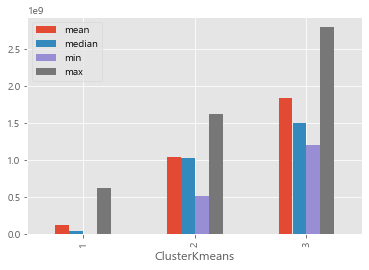

In [89]:
new_df.groupby('ClusterKmeans')['AMT'].agg(['mean','median', 'min', 'max']).plot(kind='bar')

In [90]:
cl1 = df[df['STD_CLSS_NM'].map(lambda x: x in clss_dict[0])]
cl2 = df[df['STD_CLSS_NM'].map(lambda x: x in clss_dict[1])]
cl3 = df[df['STD_CLSS_NM'].map(lambda x: x in clss_dict[2])]
#cl4 = df[df['STD_CLSS_NM'].map(lambda x: x in clss_dict[3])]

In [91]:
cl1.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,서울,건강보조식품 소매업,20s,1,1,115,7809970,140
1,201901,서울,건강보조식품 소매업,20s,2,1,407,19074744,516
2,201901,서울,건강보조식품 소매업,20s,2,2,11,868200,12
3,201901,서울,건강보조식품 소매업,30s,1,1,10,4767250,11
4,201901,서울,건강보조식품 소매업,30s,1,2,874,74320644,1045


In [92]:
cl1.to_csv('./Seoul/cl1.csv', index=False, encoding='utf-8-sig')
cl2.to_csv('./Seoul/cl2.csv', index=False, encoding='utf-8-sig')
cl3.to_csv('./Seoul/cl3.csv', index=False, encoding='utf-8-sig')
#cl4.to_csv('cl4.csv', index=False, encoding='utf-8-sig')